# Flexible buffering on islands for AMR flagregions

The [MakeFlagRegionsCoast.ipynb](http://www.clawpack.org/new_features_for_v5.7.0/notebooks_html/MakeFlagregionsCoast.html) and [MarchingFront.ipynb](http://www.clawpack.org/gallery/_static/apps/notebooks/geoclaw/MarchingFront.html#fgmax_file) notebooks illustrate tools to create AMR flagregions by choosing points along shore that satisfy elevation constraints.

Here, we will demonstrate another tool developed specifically for island regions. Since the topography can vary on each side of an island (for instance, barrier islands along the coast), we will explore a method to create a buffer zone surrounding the island, independent of water depth, and show how to make a Ruled Rectangle for AMR flagregions. 

The procedure primarily involves taking the convex hull of the island region and expanding it on all sides; this will become our buffer zone. We demonstrate this in the [first example](#example1). It is important to note that the expansion process requires the shape to be convex. 

For certain shapes of islands, the convex hull will cover a region larger than we would like. In the [second example](#example2), we explore a method to create a buffer zone that better approximates the island's shape. In particular, we partition the island, find the convex hull of each partition, and use the same buffering process on each convex hull. 

## Examples

First import some modules and set up plotting tools.

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

import netCDF4

from clawpack.visclaw import plottools
from clawpack.amrclaw import region_tools
from clawpack.geoclaw import topotools

from skimage.morphology import convex_hull, convex_hull_object
from skimage.measure import label

from scipy.spatial import ConvexHull

In [2]:
norm = mpl.colors.Normalize(vmin=0.,vmax=1.)

## Sample island topography <a name="example1"></a>

We crop a 1/3-arc-second DEM of Key West, available from the NCEI THREDDS server.

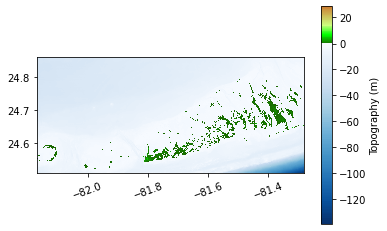

In [3]:
path = 'https://www.ngdc.noaa.gov/thredds/dodsC/regional/key_west_13_mhw_2011.nc'

extent = [-82.17, -81.28, 24.51, 24.86]
topo = topotools.read_netcdf(path, extent=extent)

topo.plot()

For simplicity, we first convert the topography to binary, setting all points above sea level to be 1 and all points sea level or below to be 0. As a result, buffering will not depend on elevation.

In [4]:
Ztopo = np.where(topo.Z <= 0, 0, 1)

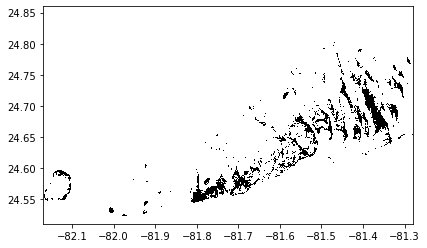

In [5]:
figure(figsize=(8,4))
plottools.pcolorcells(topo.X, topo.Y, Ztopo, cmap='Greys', norm=norm)
gca().set_aspect(1./cos(48*pi/180.))

Note: ideally `Ztopo` will only consist of island(s). If not, you can use a masked array to mask out coastal land as 0. 

### Creating a buffer region around the convex hull

We take the convex hull of all points above land. `grid_points_in_poly` tests whether points in the rectangular array lie within the convex hull. 

In [6]:
coords = np.transpose(np.nonzero(Ztopo))

hull = ConvexHull(coords)
vertices = hull.points[hull.vertices]

mask = convex_hull.grid_points_in_poly(Ztopo.shape, vertices)

Text(0.5, 1.0, 'Convex hull')

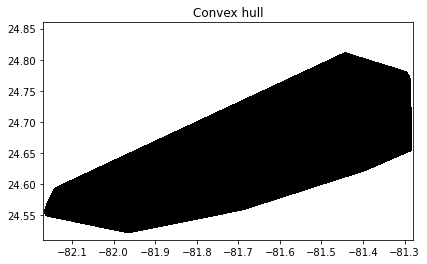

In [7]:
figure(figsize=(8,4))
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm)
gca().set_aspect(1./cos(48*pi/180.))
title('Convex hull')

The convex hull can be specified as a Ruled Rectangle using `region_tools.ruledrectangle_covering_selected_points`. 

Or, we can slightly extend the refinement region with a `buffer` function that expands the boundary of the polygon by a scalar factor.

For each side of the convex hull, we take the normalized perpendicular vector. Scaling this vector allows us to find lines parallel to the original edges, now expanded outward by a factor. The intersection of these lines will give us the vertices of the buffered convex hull.

In [8]:
def buffer(vertices, scale, plot=False):
    '''Return convex hull that is expanded by a scalar factor'''
    
    vertices = np.vstack((vertices, vertices[0]))
    
    v = [np.subtract(vertices[i+1], vertices[i]) for i in range(len(vertices)-1)]
    u = [v[i] / np.linalg.norm(v[i]) for i in range(len(v))]

    # rotate unit vectors (270 degrees if clockwise, 90 degrees if counterclockwise) 
    # to find perpendicular vectors
    n0 = [v[0][1], -v[0][0]]
    if np.dot(n0, v[1]) < 0:
        p = [[u[i][1], -1 * u[i][0]] for i in range(len(u))]
    if np.dot(n0, v[1]) > 0:
        p = [[-1 * u[i][1], u[i][0]] for i in range(len(u))]
       
    p_scaled = np.array(p) * scale
    
    # points at the end of the scaled vector
    points1 = [vertices[i] + p_scaled[i] for i in range(len(p_scaled))]
    points2 = [vertices[i+1] + p_scaled[i] for i in range(len(p_scaled))]

    for i in range(len(points1)):
        if (points2[i][0] - points1[i][0]) == 0:
            # bump point up by a small value if slope is 0
            points1[i] += 10 ** -8

    m = [(points2[i][1] - points1[i][1]) / (points2[i][0] - points1[i][0]) for i in range(len(points1))]

    intersect_pts = []
    for i in range(len(m)-1):
        x = (points1[i+1][1] - points1[i][1] + m[i]*points1[i][0] - m[i+1]*points1[i+1][0]) / (m[i] - m[i+1])
        y = m[i] * (x - points1[i][0]) + points1[i][1]
        intersect_pts.append((x,y))

    x = (points1[-1][1] - points1[0][1] + m[0]*points1[0][0] - m[-1]*points1[-1][0]) / (m[0] - m[-1])
    y = m[0] * (x - points1[0][0]) + points1[0][1]
    intersect_pts.append((x, y))

    x_space = np.linspace(0, 120, 500)
    line_eqns = [m[i] * (x_space - points1[i][0]) for i in range(len(m))]
    
    intersect_pts.append(intersect_pts[0])
    
    x, y = zip(*vertices)
    buffered_x, buffered_y = zip(*intersect_pts)
    
    buffered_mask = convex_hull.grid_points_in_poly(topo.Z.shape, intersect_pts)
    
    if plot == True:
        
        figure(figsize=(8,4))
        fill(buffered_y, buffered_x, color='lightblue', label='buffer region')
        fill(y, x, color='black', label='convex hull')
        title('Buffer region around mask')
        legend(loc='upper left')
                
    return buffered_mask

Plot the result of expanding our convex hull:

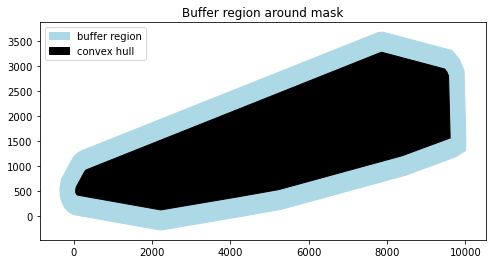

In [9]:
buffered_mask = buffer(vertices, scale=400, plot=True)

### Creating a Ruled Rectangle

Now we can define a Ruled Rectangle around our buffered convex hull. See the [flagregions documentation](https://www.clawpack.org/flagregions.html#flagregions) for writing out Ruled Rectangles as a data file to feed into GeoClaw. 

Extending rectangles to cover grid cells
RuledRectangle covers 22843894 grid points


Text(0.5, 1.0, "With ixy = 'y'")

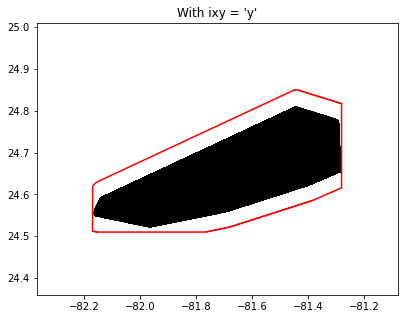

In [10]:
# extend plotting region
extend = [-.2, .2, -.15, .15]
extended_region = [x + y for x, y in zip(extent, extend)]

figure(figsize=(12,5))
rr = region_tools.ruledrectangle_covering_selected_points(topo.X, topo.Y, buffered_mask, 
                                                          ixy='y', method=0,
                                                          padding=0, verbose=True)
xv,yv = rr.vertices()
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm)
axis(extended_region)
gca().set_aspect(1./cos(48*pi/180.))
plot(xv, yv, 'r')
title("With ixy = 'y'")

The original convex hull is shown in black, and the Ruled Rectangle covers the buffered region. A few edges of the Ruled Rectangle are not extended as in the buffer because of the topography's extent. We can fix this by manually extending the Ruled Rectangle slightly to the left, right, and bottom:

Text(0.5, 1.0, "With ixy = 'y'")

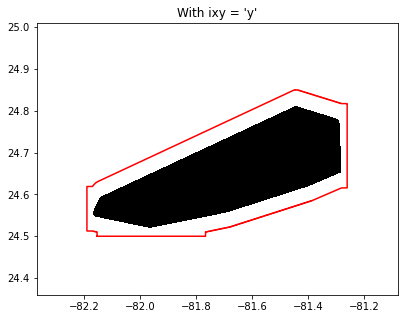

In [11]:
# extend left side
rr.lower = [lower - 0.02 if lower == min(rr.lower) else lower for lower in rr.lower]

# extend bottom
rr.s = [s - 0.01 if s == min(rr.s) else s for s in rr.s]

# extend right side
rr.upper = [upper + 0.02 if upper == max(rr.upper) else upper for upper in rr.upper]

figure(figsize=(12,5))
xv,yv = rr.vertices()
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm)
axis(extended_region)
gca().set_aspect(1./cos(48*pi/180.))
plot(xv, yv, 'r')
title("With ixy = 'y'")

## Using better convex hull approximations <a name="example2"></a>

In some cases, the convex hull around an island will span a larger region than we would like. In this example, we will repeat the buffering procedure above but use multiple convex hulls to better approximate the shape of the island.

We crop a 1/3-arc-second DEM of Cape Hatteras, available from the NCEI THREDDS server. 

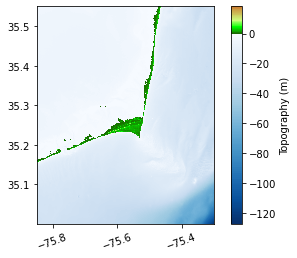

In [12]:
path = 'https://www.ngdc.noaa.gov/thredds/dodsC/regional/cape_hatteras_13_mhw_2006.nc'

extent = [-75.85, -75.3, 35.0, 35.55]
topo = topotools.read_netcdf(path, extent=extent)

topo.plot()

Like in the previous example, we convert the topography into binary and find the convex hull:

In [13]:
Ztopo = np.where(topo.Z <= 0, 0, 1)

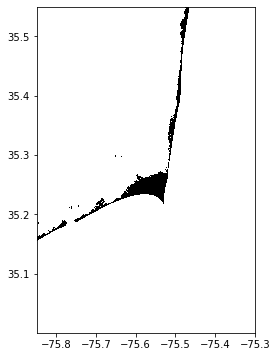

In [14]:
figure(figsize=(12,6))
plottools.pcolorcells(topo.X, topo.Y, Ztopo, cmap='Greys', norm=norm)
gca().set_aspect(1./cos(48*pi/180.))

In [15]:
coords = np.transpose(np.nonzero(Ztopo))

hull = ConvexHull(coords)
vertices = hull.points[hull.vertices]

x,y = zip(*vertices)

mask = convex_hull.grid_points_in_poly(Ztopo.shape, vertices)

Text(0.5, 1.0, 'Convex hull (non-optimal)')

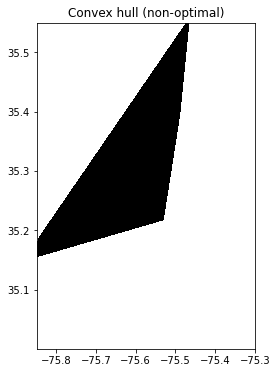

In [16]:
figure(figsize=(12,6))
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm)
gca().set_aspect(1./cos(48*pi/180.))
title('Convex hull (non-optimal)')

### Creating a partitioned convex hull

The convex hull above is a fairly inefficient approximation of the island region. Our goal is to narrow the area of refinement to better fit the shape of the island. 

To do this, we will recursively split the region in half and create seperate convex hulls for each half. Once the convexity measure of *all* partitions rises above a certain threshold, we return the union of convex hulls. 

First, we define convexity as

$$\text{convexity }=\frac{\text{island area}}{\text{convex hull area}}$$

In [17]:
def measure_convexity(Ztopo, mask):   
    '''Return convexity measure as defined above'''
    
    land_area = np.count_nonzero(Ztopo)
    chull_area = np.count_nonzero(mask)
    
    # if partition does not contain land, compute convexity measure to be 1 
    if land_area == 0:
        return 1
    else:
        return land_area / chull_area

If there are multiple islands in our region of interest, we will treat them as separate objects. In addition to taking the convex hull of each partition, then, we will also take the convex hull of each connected component. To do this, we label and create a hull object for each component:

In [18]:
def chull_objects(Ztopo):
    '''Return convex hull of entire topo and list of convex hull objects for each connected component'''
    
    chull = np.zeros(Ztopo.shape, dtype=bool)
    obj = []
    
    labeled_topo = label(Ztopo, connectivity=2, background=0)
        
    for i in range(1, labeled_topo.max() + 1):
        coords = np.transpose(np.nonzero(labeled_topo == i))
        
        # ignore small dots
        if len(coords) < 3:
            continue
        
        # if points are on same line, group with next labeled object
        if (all([c[0] == coords[0][0] for c in coords]) or all([c[1] == coords[0][1] for c in coords])):
            labeled_topo = np.where(labeled_topo == i, i+1, labeled_topo)
        else:        
            hull = ConvexHull(coords)
            obj.append(hull)
        
            vertices = hull.points[hull.vertices]        
            mask = convex_hull.grid_points_in_poly(labeled_topo.shape, vertices)
            chull = np.logical_or(chull, mask)
    
    return chull, obj

Now, we create the recursive function. In each iteration, the function splits the binary topograpy (or a section of the topography) in half and computes the convexity measure. If the convexity falls below our threshold in any half, we constrain `Ztopo` to that half by redefining the starting and ending indices. The function repeatedly partitions the topography, until the convexity of all partitions reach the treshold, while adding the hull objects to a list. 

Note that a lower threshold will give a coarser approximation, while a higher threshold will give a finer approximation. 

Also note that the function splits the topography vertically. If you would like to split the topography horizontally, you can simply change the slicing. 

In [19]:
def partitioned_chull(Ztopo, threshold, start=0, convexity=0, end=0):
    '''Finds each convex object in a partitioned convex hull'''
    
    global objects
    
    if convexity >= threshold:
        return convex_hull_object(Ztopo)
    
    mid_col = int(np.floor((start + end) / 2))
    
    Ztopo[:, 0:start] = 0
    Ztopo[:, end:len(Ztopo)] = 0
    
    topo_left = Ztopo.copy()
    topo_left[:, mid_col:] = 0
    topo_right = Ztopo.copy()
    topo_right[:, 0:mid_col] = 0
    
    chull_left, obj_left = chull_objects(topo_left)
    chull_right, obj_right = chull_objects(topo_right)
    
    conv_left = measure_convexity(topo_left, chull_left)
    conv_right = measure_convexity(topo_right, chull_right)
    
    print('Convexity of left half: ', conv_left)
    print('Convexity of right half: ', conv_right) 
    
    if conv_left >= threshold:
        objects.extend(obj_left)
        print('Left half satisfied')
    if conv_right >= threshold:
        objects.extend(obj_right)
        print('Right half satisfied')    

    if conv_left < threshold or conv_right < threshold: 
        
        chull_left = partitioned_chull(Ztopo, threshold=threshold, convexity=conv_left, start=start, end=mid_col)
        chull_right = partitioned_chull(Ztopo, threshold=threshold, convexity=conv_right, start=mid_col+1, end=end)

        return np.logical_or(chull_left, chull_right)
    
    else:

        return np.logical_or(chull_left, chull_right)

Let's try it on our Cape Hatteras topography:

In [20]:
objects = []
chull = partitioned_chull(Ztopo, threshold=0.4, end=len(Ztopo))

Convexity of left half:  0.46072521666290794
Convexity of right half:  0.3253215514315942
Left half satisfied
Convexity of left half:  0.32538890812711435
Convexity of right half:  1
Right half satisfied
Convexity of left half:  0.489490434318509
Convexity of right half:  0.5094851236964442
Left half satisfied
Right half satisfied


We can combine all of our convex hull objects into a single mask by taking the logical OR:

In [21]:
mask = np.zeros(Ztopo.shape, dtype=bool)

for obj in objects:
    
    vertices = obj.points[obj.vertices]    
    
    obj_mask = convex_hull.grid_points_in_poly(Ztopo.shape, vertices)
    mask = np.logical_or(mask, obj_mask)

Text(0.5, 1.0, 'Partitioned convex hull')

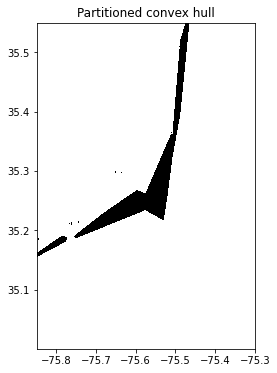

In [22]:
figure(figsize=(12,6))
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm)
gca().set_aspect(1./cos(48*pi/180.))
title('Partitioned convex hull')

### Creating ruled rectangles around the buffered region

Now we can apply the buffering function on each convex hull object. We can then either define Ruled Rectangles for each convex hull object or define a Ruled Rectangle for the entire mask. The first option may be useful if island points are fairly scattered in the topography. The second option may be simpler if the points are more concentrated. 

For this example, we will skip some small objects (fewer than 1000 points). You might want to experiment with which objects to include. You will also likely want to toggle the scale to change the buffering amount. 

In [23]:
rrs = []
buffered_mask = np.zeros(Ztopo.shape, dtype=bool)

for obj in objects:
    
    vertices = obj.points[obj.vertices]    
    
    obj_mask = convex_hull.grid_points_in_poly(Ztopo.shape, vertices)
    area = np.count_nonzero(obj_mask)   
    
    if area < 1000:
        continue
    
    buffered_obj = buffer(vertices, scale=200, plot=False)
    
    # for option 1
    rr = region_tools.ruledrectangle_covering_selected_points(topo.X, topo.Y, buffered_obj, 
                                                         ixy='x', method=0,
                                                         padding=0, verbose=True)
    rrs.append(rr)  
    
    # for option 2
    buffered_mask = np.logical_or(buffered_mask, buffered_obj)

Extending rectangles to cover grid cells
RuledRectangle covers 529971 grid points
Extending rectangles to cover grid cells
RuledRectangle covers 1543807 grid points
Extending rectangles to cover grid cells
RuledRectangle covers 191636 grid points
Extending rectangles to cover grid cells
RuledRectangle covers 155902 grid points
Extending rectangles to cover grid cells
RuledRectangle covers 1492339 grid points
Extending rectangles to cover grid cells
RuledRectangle covers 1482039 grid points


Plot Ruled Rectangles covering each object:

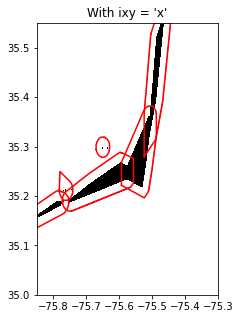

In [24]:
figure(figsize=(12,5))
axis(extent) 
title("With ixy = 'x'")
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm) 

for rr in rrs:
    
    xv,yv = rr.vertices()
    
    plt.gca().set_aspect(1./cos(48*pi/180.))
    plt.plot(xv, yv, 'r')    

Create and plot Ruled Rectangle covering the entire buffered region:

Text(0.5, 1.0, "With ixy = 'y'")

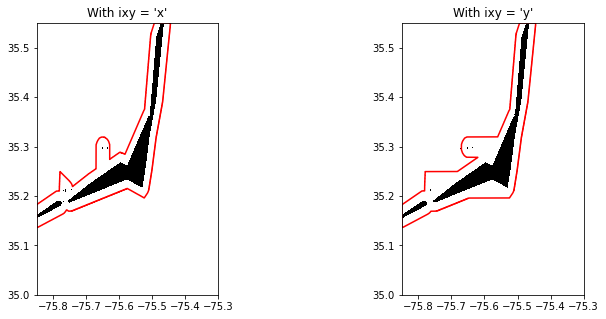

In [25]:
figure(figsize=(12,5))
subplot(121)
rr2 = region_tools.ruledrectangle_covering_selected_points(topo.X, topo.Y, buffered_mask, 
                                                          ixy='x', method=0,
                                                          padding=0, verbose=False)
xv,yv = rr2.vertices()
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm)
axis(extent) 
gca().set_aspect(1./cos(48*pi/180.))
plot(xv, yv, 'r')
title("With ixy = 'x'")

subplot(122)
rr2 = region_tools.ruledrectangle_covering_selected_points(topo.X, topo.Y, buffered_mask, 
                                                          ixy='y', method=0,
                                                          padding=0, verbose=False)
xv,yv = rr2.vertices()
plottools.pcolorcells(topo.X, topo.Y, mask, cmap='Greys', norm=norm)
axis(extent) 
gca().set_aspect(1./cos(48*pi/180.))
plot(xv, yv, 'r')
title("With ixy = 'y'")